In [1]:
import warnings
import pandas as pd  
import numpy as np   


import matplotlib.pyplot as plt
# Scaling Package
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  


import tensorflow as tf   
import keras    
from keras import models 
from keras import layers 
from keras import optimizers
import random
random.seed(2505)  

warnings.filterwarnings('ignore', category=FutureWarning, module='yfinance|pandas')

/var/folders/5f/fp3kjq817_z7nc68b5qngk580000gn/T/ipykernel_74819/2425654981.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('AAPL_data.csv')    

df.drop(columns='Name',inplace=True) 


# converting dates to datetime 
df['date'] = pd.to_datetime(df['date']) 

df.set_index('date', inplace= True)      


print(df.shape)  

df.head()

(1259, 5)


,open,high,low,close,volume
date,,,,,
2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416
2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425
2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363
2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995
2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154


In [3]:
df['mv_avg_short'] = df['close'].rolling(window=5).mean() 
df['mv_avg_long'] = df['close'].rolling(window=50).mean()

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = pd.DataFrame(scaler.fit_transform(df[["high","low","open","close","volume",
                                                 "mv_avg_short","mv_avg_long"]].values)) 
 
df_scaled = df_scaled.iloc[50:,:] 

df_scaled.head()

,0,1,2,3,4,5,6
50,0.010197,0.015893,0.018465,0.018050,0.584611,0.000000,0.011221
51,0.018174,0.008579,0.006420,0.017277,0.904267,0.000627,0.009320
52,0.016653,0.025387,0.026804,0.020653,0.330944,0.004473,0.007801
53,0.022261,0.026836,0.025172,0.030864,0.703054,0.010756,0.006529
54,0.039504,0.040457,0.037436,0.045807,0.581471,0.018163,0.005598


In [5]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 60 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(df_scaled.shape[0] - samples): 
    X.append(df_scaled.iloc[i:i+samples,[0,1,2,4,5,6]].values) # Independent Samples
    Y.append(df_scaled.iloc[i+samples, [3]].values) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

Training Data: Length is  60 :  [array([[1.01971885e-02, 1.58931090e-02, 1.84645224e-02, 5.84610720e-01,
        0.00000000e+00, 1.12213990e-02],
       [1.81743098e-02, 8.57867600e-03, 6.41974153e-03, 9.04267406e-01,
        6.26989844e-04, 9.32025238e-03],
       [1.66525355e-02, 2.53871034e-02, 2.68036513e-02, 3.30943565e-01,
        4.47301116e-03, 7.80071827e-03],
       [2.22608266e-02, 2.68363576e-02, 2.51722931e-02, 7.03053555e-01,
        1.07557692e-02, 6.52923052e-03],
       [3.95035374e-02, 4.04565881e-02, 3.74357179e-02, 5.81470533e-01,
        1.81630863e-02, 5.59818103e-03],
       [5.30133489e-02, 5.44484638e-02, 5.43213243e-02, 6.31512987e-01,
        2.67950366e-02, 5.15446756e-03],
       [5.26418473e-02, 5.71384289e-02, 6.51091041e-02, 4.51305496e-01,
        3.47624074e-02, 4.62601088e-03],
       [5.68917597e-02, 6.43717167e-02, 6.20206574e-02, 3.68006021e-01,
        4.35099297e-02, 4.54099961e-03],
       [6.22805641e-02, 7.42479052e-02, 7.30044907e-02, 3.08756

In [6]:
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

Dimensions of X (1149, 60, 6) Dimensions of Y (1149, 1)


In [7]:
# # Get the training and testing set
threshold = round(0.9 * X.shape[0])
trainX, trainY = X[:threshold], Y[:threshold]
testX, testY =  X[threshold:], Y[threshold:]
print('Training Length',trainX.shape, trainY.shape,'Testing Length:',testX.shape, testY.shape)

Training Length (1034, 60, 6) (1034, 1) Testing Length: (115, 60, 6) (115, 1)


In [10]:
regressor = models.Sequential()

# add first layer with dropout

regressor.add(layers.LSTM(units=50, return_sequences=True, input_shape=(X.shape[1],X.shape[2])))
regressor.add(layers.Dropout(0.2))

# add second layer

regressor.add(layers.LSTM(units=50, return_sequences=True))
regressor.add(layers.Dropout(0.2))

# add third layer

regressor.add(layers.LSTM(units=50, return_sequences=True))
regressor.add(layers.Dropout(0.2))

# add fourth layer

regressor.add(layers.LSTM(units=50))
regressor.add(layers.Dropout(0.2))

# the output layer

regressor.add(layers.Dense(units=1))    


regressor.compile(optimizer = tf.keras.optimizers.Adam(), loss='mean_squared_error')  

regressor.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 50)            11400     
                                                                 
 dropout_8 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

In [12]:
lstm_trained = regressor.fit(trainX,
                              trainY,
                              shuffle = False, # Since this is time series data
                              epochs=50,
                              batch_size=32,
                              validation_split=0.2,
                              verbose=1) # Verbose outputs data

Epoch 1/50
26/26 [==============================] - 1s 33ms/step - loss: 0.0025 - val_loss: 0.0070
Epoch 2/50
26/26 [==============================] - 1s 33ms/step - loss: 0.0048 - val_loss: 0.0182
Epoch 3/50
26/26 [==============================] - 1s 34ms/step - loss: 0.0086 - val_loss: 0.0063
Epoch 4/50
26/26 [==============================] - 1s 33ms/step - loss: 0.0046 - val_loss: 0.0076
Epoch 5/50
26/26 [==============================] - 1s 33ms/step - loss: 0.0040 - val_loss: 0.0090
Epoch 6/50
26/26 [==============================] - 1s 33ms/step - loss: 0.0038 - val_loss: 0.0081
Epoch 7/50
26/26 [==============================] - 1s 33ms/step - loss: 0.0034 - val_loss: 0.0074
Epoch 8/50
26/26 [==============================] - 1s 33ms/step - loss: 0.0035 - val_loss: 0.0089
Epoch 9/50
26/26 [==============================] - 1s 33ms/step - loss: 0.0038 - val_loss: 0.0094
Epoch 10/50
26/26 [==============================] - 1s 33ms/step - loss: 0.0039 - val_loss: 0.0061
Epoch 11/

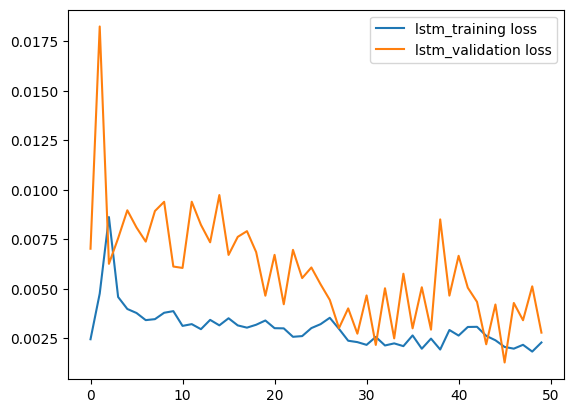

In [13]:
plt.plot(lstm_trained.history['loss'], label = 'lstm_training loss')
plt.plot(lstm_trained.history['val_loss'], label ='lstm_validation loss')
plt.legend()

4/4 [==============================] - 1s 7ms/step


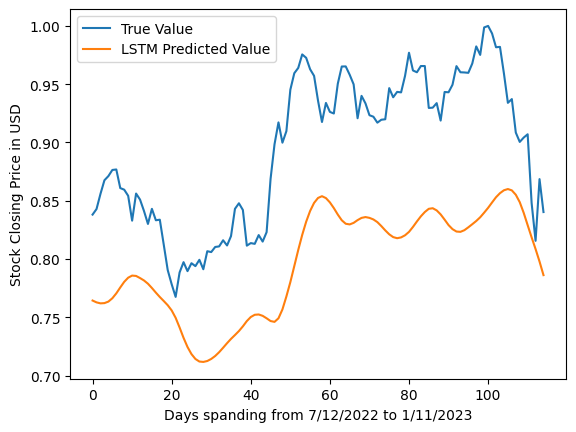

In [14]:
y_pred = regressor.predict(testX)       
testY = testY   
y_pred = y_pred
plt.plot(testY, label = 'True Value')   
plt.plot(y_pred[:,0],label='LSTM Predicted Value')  
plt.xlabel("Days spanding from 7/12/2022 to 1/11/2023") 
plt.ylabel("Stock Closing Price in USD")
plt.legend()

In [15]:

output_index = 0  # Index of the output column to evaluate
mse = mean_squared_error(testY, y_pred)
mae = mean_absolute_error(testY, y_pred)
r2 = r2_score(testY, y_pred) 


print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)

Mean Squared Error (MSE): 0.010731666469171725
Mean Absolute Error (MAE): 0.09746987254702316
R-squared Score (R2): -1.6103533785444806
